In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
df50 = pd.read_csv('../DE_N250.csv', index_col='Unnamed: 0')
df58 = pd.read_csv('../DE_N258.csv', index_col='Unnamed: 0')
detected = np.intersect1d(df50.index.values.tolist(), df58.index.values.tolist())
print(df50.shape)
print(df58.shape)

(16021, 9)
(15461, 9)


In [3]:
sig50 = df50[df50.padj < 0.05].index.values
sig58 = df58[df58.padj < 0.05].index.values
union = list(set(sig50.tolist() + sig58.tolist()))
intersect = np.intersect1d(sig50, sig58)

In [4]:
print('In 50 hrs: ', len(sig50))
print('In 58 hrs: ', len(sig58))
print('In union: ', len(union))
print('In intersection: ', len(intersect))

In 50 hrs:  1756
In 58 hrs:  610
In union:  2017
In intersection:  349


In [5]:
df50.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,SNR,logq
WBGene00006927,58181.898727,0.586361,0.012837,45.677295,0.000000e+00,0.000000e+00,vit-3,0.000010,inf
WBGene00006928,68103.528654,0.585063,0.015865,36.877363,1.065766e-297,6.384471e-294,vit-4,0.000009,293.194875
WBGene00006925,47920.805501,0.582418,0.016354,35.612173,9.078855e-278,3.625792e-274,vit-1,0.000012,273.440597
WBGene00001564,44177.512190,-0.510046,0.014997,-34.009264,1.625338e-253,4.868293e-250,icl-1,-0.000012,249.312623
WBGene00018393,12389.581314,0.570855,0.019901,28.684021,6.037800e-181,1.446778e-177,msra-1,0.000046,176.839598


(1753, 9)

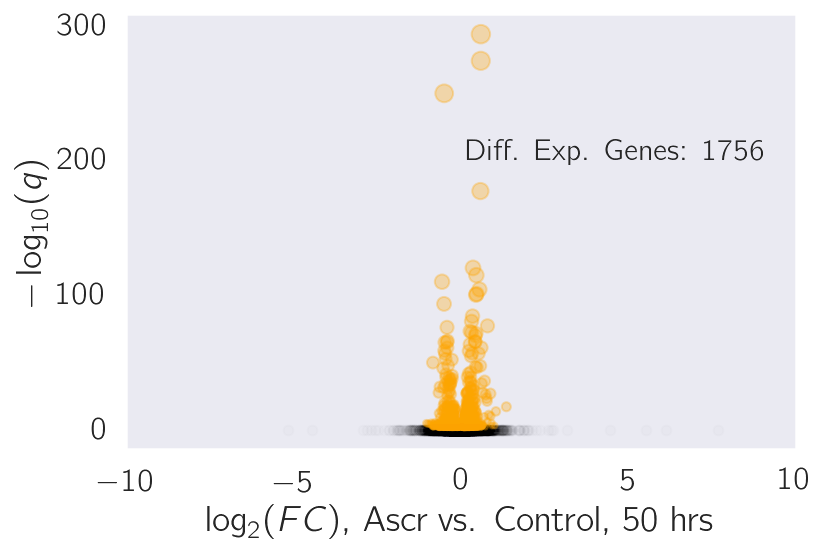

In [6]:
def volcano_plot(df, alpha=0.05):
    sig = df.padj < alpha
    ns = df.padj > 1 - alpha
    
    xns = df[ns].log2FoldChange
    yns = df[ns].logq

    xsig = df[sig].log2FoldChange
    ysig = df[sig].logq.replace(np.inf, 300)
    
    plt.scatter(xns, yns, s=25, alpha=0.01, color='black')
    plt.scatter(xsig, ysig, s=df[sig].logq.apply(np.sqrt) * 5,
                alpha=0.3, color='orange')
    plt.ylabel('$-\log_{10}(q)$')

    maxsig = np.max(xsig.abs())
    lim = maxsig + maxsig / 10
    
    plt.annotate('Diff. Exp. Genes: {0}'.format(len(ysig)),
                 (lim - 10 * maxsig / 10, ysig.max() * 2 / 3),
                 fontsize=15)
    plt.xlim(-lim, lim)

volcano_plot(df50)
plt.xlim(-10, 10)
plt.xlabel('$\log_2(FC)$, Ascr vs. Control, 50 hrs')
plt.savefig('../volcano_50hrs.pdf', bbox_inches='tight')
df50[df50.padj < 10 ** -10].shape
df50[(df50.padj < 0.05) & (df50.log2FoldChange.abs() < 1)].shape

(481, 9)

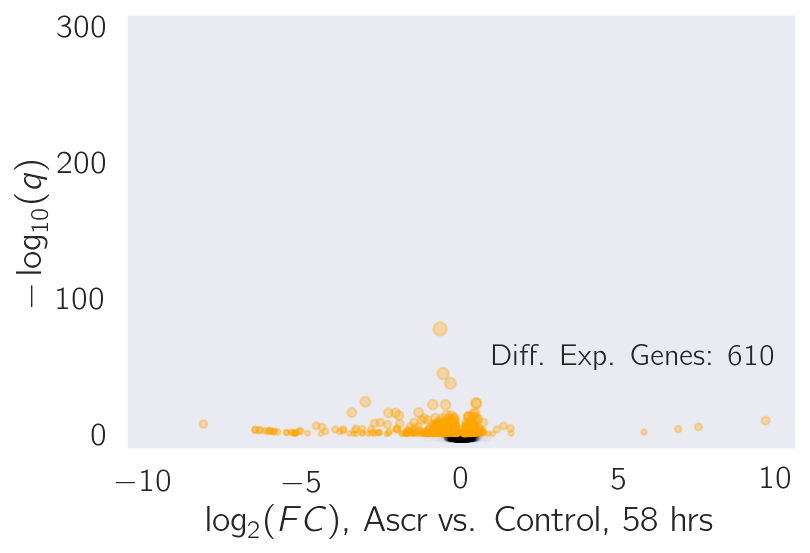

In [7]:
volcano_plot(df58)
plt.ylim(-10, 310)
plt.xlabel('$\log_2(FC)$, Ascr vs. Control, 58 hrs')
plt.savefig('../volcano_58hrs.pdf', bbox_inches='tight')
# df58[(df58.padj < 0.05) & (df58.log2FoldChange > 0)].shape
df58[(df58.padj < 0.05) & (df58.log2FoldChange.abs() < 1)].shape

In [8]:
df50.reset_index(inplace=True)
df58.reset_index(inplace=True)

In [9]:
df50.columns = ['gene'] + df50.columns[1:].tolist()
df58.columns = ['gene'] + df58.columns[1:].tolist()

In [10]:
sub50 = df50[df50.gene.isin(union)].sort_values('gene').copy()
sub58 = df58[df58.gene.isin(union)].sort_values('gene').copy()

In [11]:
merged = sub50.merge(sub58, left_on='gene', right_on='gene', suffixes=('50h', '58h'))

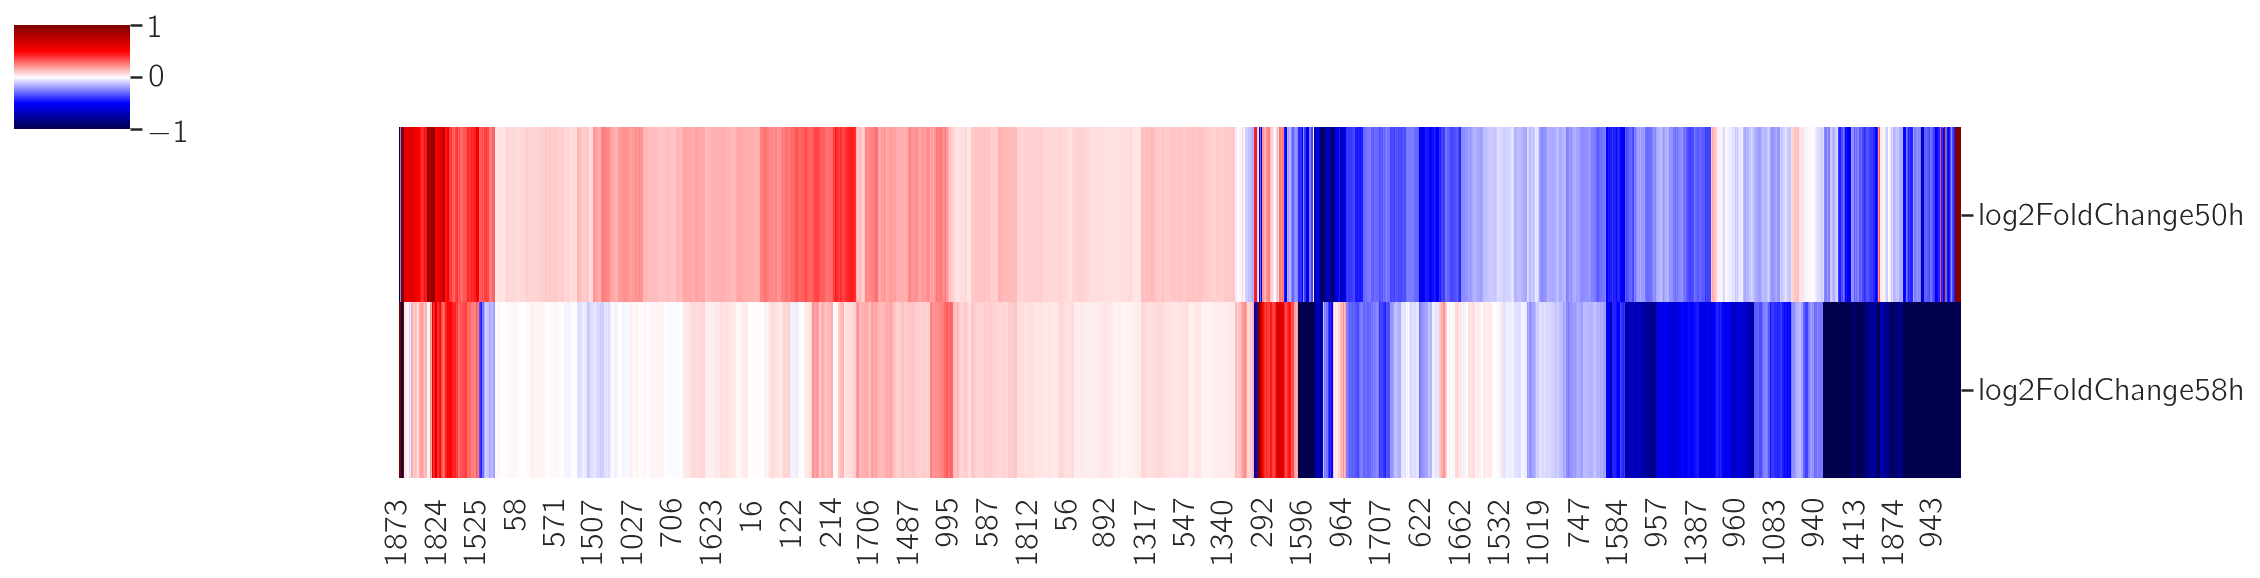

In [12]:
cg = sns.clustermap(merged[['log2FoldChange50h', 'log2FoldChange58h']].T, figsize=(16, 4), cmap='seismic', center=0,
                    vmin=-1, vmax=1, method='weighted', row_cluster=True)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

plt.savefig('../heatmap_union.svg', bbox_inches='tight')

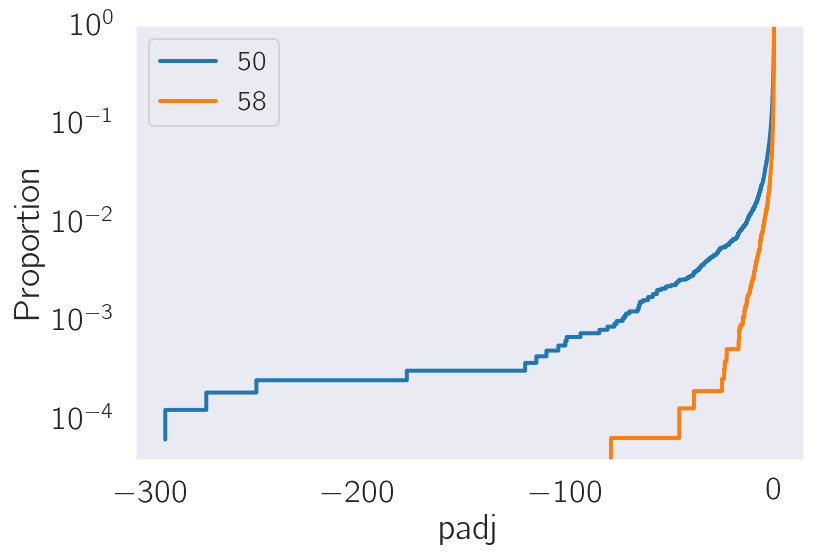

In [13]:
sns.ecdfplot(df50.padj.apply(np.log10), label='50')
sns.ecdfplot(df58.padj.apply(np.log10), label='58')
plt.yscale('log')
plt.legend()

##### 

In [14]:
# Hypergeom calculation:
df50 = df50[df50.gene.isin(detected)]
df58 = df58[df58.gene.isin(detected)]

# DEGs out of commonly detected expression levels:
sig50 = df50[df50.padj < 0.05].gene.values
sig58 = df58[df58.padj < 0.05].gene.values

# find union:
union = list(set(sig50.tolist() + sig58.tolist()))
intersect = np.intersect1d(sig50, sig58)
print(len(detected))

14972


In [15]:
print('In 50 hrs: ', len(sig50))
print('In 58 hrs: ', len(sig58))
print('In union: ', len(union))
print('In intersection: ', len(intersect))

In 50 hrs:  1745
In 58 hrs:  587
In union:  1983
In intersection:  349


In [38]:
[M, n, N] = [len(detected),
             np.max([len(sig50), len(sig58)]),
             np.min([len(sig50), len(sig58)])
            ]
k = len(intersect)
scipy.stats.hypergeom.sf(k - 1, M, n, N)

9.385517773736865e-181